In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from itertools import combinations
from itertools import permutations
warnings.filterwarnings('ignore')

tutorial to execute this notebook:
1. create a drive folder(in your private drive) called ekimetrics (the name should be the same as written here 
2. create inside another folder called "data"
3. put all the datas we are given inside that folder(with the same file names) 
4. execute the notebook and follow the further instructions on the output 

In [2]:
!pip install httplib2==0.15.0

!pip install google-api-python-client==1.6

     |████████████████████████████████| 102kB 4.0MB/s 
  Found existing installation: httplib2 0.17.4
    Uninstalling httplib2-0.17.4:
      Successfully uninstalled httplib2-0.17.4
     |████████████████████████████████| 61kB 3.0MB/s 
ERROR: firebase-admin 4.4.0 has requirement google-api-python-client>=1.7.8, but you'll have google-api-python-client 1.6.0 which is incompatible.
ERROR: earthengine-api 0.1.264 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.6.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
contacts = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Contacts.xlsx')


In [6]:
don_2018 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2018.xlsx')
don_2017 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2017.xlsx')
don_2016 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2016.xlsx')
don_2015 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2015.xlsx')
don_2014 = pd.read_excel('/content/drive/MyDrive/ekimetrics/data/Dons_2014.xlsx')

In [7]:
donors=pd.concat([don_2018,don_2017,don_2016,don_2015])

In [8]:
donations=donors.merge(contacts,how="inner",left_on="contact ID",right_on="ID_CTC")

In [9]:
donations.columns

Index(['Batch number', 'Receipt date', 'contact ID', 'Amount of transaction',
       'cam code', 'Operation', 'Segment', 'Movement Id', 'Ventilation Id',
       'oft code', 'payment method', 'ventilation amount', 'RF', 'Unnamed: 0',
       'ID_CTC', 'Contact Type', 'BIRTH_DATE', 'CREATION_DATE', 'Dead',
       'Mailing address', 'COUNTRY', 'EMAIL', 'Email', 'Optin', 'Phone',
       'Stop Phone', 'Stop mailing', 'Stop', 'NPAI>2', 'SEGMENT_ORIGIN',
       'DONATION_NUMBER', 'DONATION_AMOUNT', 'FIRST_DONATION_DATE',
       'LAST_DONATION_DATE', 'FIRST_DONATION_SOURCE', 'LAST_DONATION_SOURCE',
       'FIRST_DONATION_AMOUNT', 'LAST_DONATION_AMOUNT',
       'YEAR_N_DONATION VOLUME', 'YEAR_N1_DONATION VOLUME',
       'YEAR_N2_DONATION VOLUME', 'YEAR_N3_DONATION VOLUME',
       'YEAR_N4_DONATION VOLUME', 'YEAR_N_DONATION_AMOUNT',
       'YEAR_N1_DONATION_AMOUNT', 'YEAR_N2_DONATION_AMOUNT',
       'YEAR_N3_DONATION_AMOUNT', 'YEAR_N4_DONATION_AMOUNT', 'PA_ACTIVE',
       'STARTING_DATE_ACTIVE_PA

In [10]:
donations.head(10)

,Batch number,Receipt date,contact ID,Amount of transaction,cam code,Operation,Segment,Movement Id,Ventilation Id,oft code,payment method,ventilation amount,RF,Unnamed: 0,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,EMAIL,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,DONATION_NUMBER,DONATION_AMOUNT,FIRST_DONATION_DATE,LAST_DONATION_DATE,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,YEAR_N_DONATION VOLUME,YEAR_N1_DONATION VOLUME,YEAR_N2_DONATION VOLUME,YEAR_N3_DONATION VOLUME,YEAR_N4_DONATION VOLUME,YEAR_N_DONATION_AMOUNT,YEAR_N1_DONATION_AMOUNT,YEAR_N2_DONATION_AMOUNT,YEAR_N3_DONATION_AMOUNT,YEAR_N4_DONATION_AMOUNT,PA_ACTIVE,STARTING_DATE_ACTIVE_PA,ENDING_DATE_ACTIVE_PA,ACTIVE_PA_CYCLE,DATE_LAST_ACTIVE_PA,ACTIVE_PA_ORIGIN,DEBIT_NUMBER,DEBIT_AMOUNT,FIRST_DEBIT_DATE,LAST_DEBIT_DATE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,MIN_VALUE_OF_PURCHASE,FIRST_PURCHASE_DATE,LAST_PURCHASE_DATE,SUBSCRIPTION_NUMBER,SUBSCRIPTION_AMOUNT,FIRST_SUBSCRIPTION_DATE,LAST_SUBSCRIPTION_DATE,NOMBRE_PETITION,FIRST_PETITION_DATE,LAST_PETITION_DATE
0,41742,2018-01-01,759409,10.0,SITE,SITEVA,SITEVA,1909872.0,3115790.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
1,42147,2018-02-28,759409,10.0,SITE,SITEVA,SITEVA,1947901.0,3153849.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2,42313,2018-03-31,759409,10.0,SITE,SITEVA,SITEVA,1995267.0,3201219.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,42449,2018-04-30,759409,10.0,SITE,SITEVA,SITEVA,2007912.0,3213865.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
4,42590,2018-05-31,759409,10.0,SITE,SITEVA,SITEVA,2009561.0,3215523.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
5,42806,2018-06-30,759409,10.0,SITE,SITEVA,SITEVA,2022672.0,3228647.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
6,42934,2018-07-31,759409,10.0,SITE,SITEVA,SITEVA,2046729.0,3252728.0,DON,CB,10.0,Oui,121218,759409,PHYSICAL,NaN,20110630,NaN,yes,FR,c32019e3c5d0d1f3cda1d4bab39d7ca330b8ddeaf16259...,yes,yes,yes,NaN,NaN,NaN,NaN,TW2011PFD,11.0,150.0,20110430.0,20180930.0,TW2011PFD,SITEVA,30.0,10.0,9.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
7,4

In [11]:
donations["Receipt date"].iloc[3]

Timestamp('2018-04-30 00:00:00')

In [12]:
donations_grouped=donations.groupby(["contact ID"]).apply(lambda x: x.sort_values(by=["Receipt date"]))

In [13]:
donations_grouped

Batch number  ... LAST_PETITION_DATE
contact ID                       ...                   
2          400973         35455  ...                NaN
           400974         35460  ...                NaN
           400970         38951  ...                NaN
           400971         39460  ...                NaN
           400972         41546  ...                NaN
...                         ...  ...                ...
1376608    419227         43149  ...                NaN
1376610    419228         43149  ...                NaN
1376616    419229         43149  ...                NaN
1376618    419233         43149  ...                NaN
1376621    419232         43149  ...                NaN

[555669 rows x 70 columns]

the main idea is to group the donors by 3 main characteristics, total money spent, number of transactions,numbers of  days from the last transaction(computed as the difference between the last day of our time range in analysis and the last transaction made by the customer) <br>


nb: i used the transaction data instead of customer data, because i would be able to compute the analysis at different times in order to compute a better eventual transition matrix, we will use customer data after the clustering, because in this way i will be able to create the personas 

In [14]:
transactions_grouped=donors.groupby(["contact ID"]).apply(lambda x: x.sort_values(by=["Receipt date"]))

we first get the frequency of transactions by customer 

In [15]:
frequencies=donors.groupby(["contact ID"]).size().reset_index(name='counts')

In [16]:
frequencies.head(10)

,contact ID,counts
0,2,7
1,16,1
2,26,6
3,55,50
4,76,9
5,112,50
6,116,4
7,135,42
8,170,51
9,192,9


then the total amount donated 

In [17]:
amounts=donors[["contact ID","Amount of transaction"]].groupby(["contact ID"])["Amount of transaction"].sum().reset_index(name='total_transaction')

In [18]:
amounts.head(10)

,contact ID,total_transaction
0,2,90.0
1,16,40.0
2,26,730.0
3,55,422.0
4,76,210.0
5,112,376.0
6,116,250.0
7,135,246.0
8,170,470.0
9,192,500.0


then we get the number of days from the last transaction of each customer 

In [19]:
last_date=donors["Receipt date"].max() #last date in our subset 

In [20]:
last_date

Timestamp('2018-12-31 00:00:00')

In [21]:
days_last_transaction=donors.groupby(["contact ID"])["Receipt date"].apply(lambda x: last_date-x.max()).reset_index(name='days_last_transaction')


In [22]:
days_last_transaction.head(10)

,contact ID,days_last_transaction
0,2,14 days
1,16,812 days
2,26,54 days
3,55,0 days
4,76,63 days
5,112,21 days
6,116,85 days
7,135,174 days
8,170,21 days
9,192,319 days


In [23]:
days_last_transaction["days_last_transaction"]=days_last_transaction["days_last_transaction"].dt.days

In [24]:
days_last_transaction

,contact ID,days_last_transaction
0,2,14
1,16,812
2,26,54
3,55,0
4,76,63
...,...,...
102454,1397502,0
102455,1397588,0
102456,1397591,0
102457,1397594,0


we finally merge ou findings per costumer

In [25]:
matrix=frequencies.merge(amounts,how="inner",left_on="contact ID", right_on="contact ID").merge(days_last_transaction,how="inner",left_on="contact ID",right_on="contact ID")

In [26]:
matrix

,contact ID,counts,total_transaction,days_last_transaction
0,2,7,90.0,14
1,16,1,40.0,812
2,26,6,730.0,54
3,55,50,422.0,0
4,76,9,210.0,63
...,...,...,...,...
102454,1397502,1,30.0,0
102455,1397588,1,25.0,0
102456,1397591,1,20.0,0
102457,1397594,1,50.0,0


lets plot the distributions

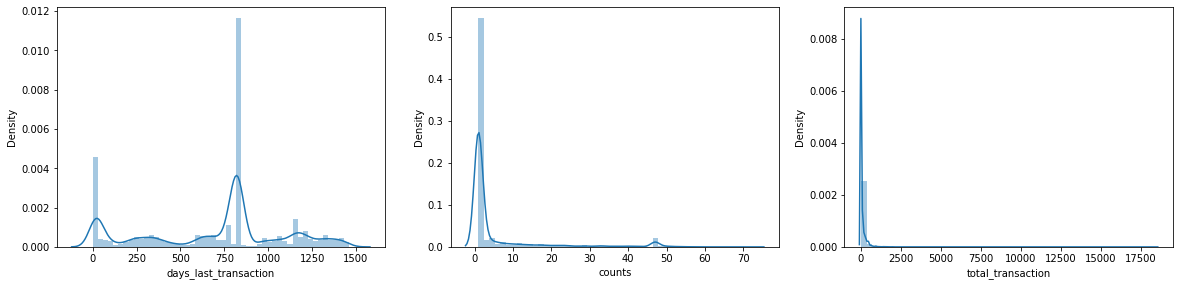

In [27]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.distplot(matrix['days_last_transaction'])
plt.subplot(3, 3, 2)
sns.distplot(matrix['counts'])
plt.subplot(3, 3, 3)
sns.distplot(matrix['total_transaction'])

as is possible to see, the distribution of the number of transaction per customer and the total donated amount are skewed, so we cannot use a quantile approach to find the cutoffs

In [28]:
def sorted_kmeans(df, metric_column, cluster_name, ascending=True, log=False):

    if log:
        df[metric_column] = np.log(df[metric_column]+1)

  
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df[[metric_column]])

    
    initial_cluster = 'unsorted_'+cluster_name
    df[initial_cluster] = kmeans.predict(df[[metric_column]])+1
    df[cluster_name] = df[initial_cluster]

    df_sorted = df.groupby(initial_cluster)[metric_column].mean().round(2).reset_index()
    df_sorted = df_sorted.sort_values(by=metric_column, ascending=ascending).reset_index(drop=True)
    df_sorted[cluster_name] = df_sorted[metric_column].rank(method='max', ascending=ascending).astype(int)

    df = df.merge(df_sorted[[cluster_name, initial_cluster]], on=[initial_cluster])
    df = df.drop(initial_cluster, axis=1)
    df = df.drop(cluster_name+'_x', axis=1)
    df = df.rename(columns={cluster_name+'_y':cluster_name})

    return df

after finding the optimal cutoff using kmeans we categorize our datas 

In [29]:
matrix = sorted_kmeans(matrix, 'days_last_transaction', 'score_days', ascending=True)
matrix = sorted_kmeans(matrix, 'counts', 'score_count', ascending=False)
matrix = sorted_kmeans(matrix, 'total_transaction', 'score_money', ascending=False)


here is our final result, less is the score, better it is 

In [30]:
matrix.head(10)

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money
0,2,7,90.0,14,1,3,4
1,76,9,210.0,63,1,3,4
2,1796,9,215.0,87,1,3,4
3,2188,10,206.0,173,1,3,4
4,2678,13,17.1,5,1,3,4
5,2869,9,225.0,178,1,3,4
6,4622,8,85.0,14,1,3,4
7,5848,9,150.0,160,1,3,4
8,5936,14,205.0,51,1,3,4
9,6382,9,170.0,4,1,3,4


as is possible to see from this plot the majority of customers are donating litte amounts (0-228 €)

In [31]:
matrix.groupby('score_money').agg(
    number_donors=('contact ID', 'count'),
    min_money=('total_transaction', min),
    max_money=('total_transaction', max),
    
)

,number_donors,min_money,max_money
score_money,,,
1,23,5890.0,18475.0
2,588,1120.0,5250.0
3,10839,228.6,1111.0
4,91009,0.0,228.0


the majority of customers donate only one time 

In [32]:
matrix.groupby('score_count').agg(
    number_donors=('contact ID', 'count'),
    min_count=('counts', min),
    max_count=('counts', max),
    
)

,number_donors,min_count,max_count
score_count,,,
1,5460,36,72
2,4331,19,35
3,7336,7,18
4,85332,1,6


In [33]:
matrix.groupby('score_days').agg(
    number_donors=('contact ID', 'count'),
    min_days=('days_last_transaction', min),
    max_days=('days_last_transaction', max),
    
)

,number_donors,min_days,max_days
score_days,,,
1,17702,0,184
2,12560,185,566
3,51236,567,1004
4,20961,1035,1460


In [34]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money
0,2,7,90.0,14,1,3,4
1,76,9,210.0,63,1,3,4
2,1796,9,215.0,87,1,3,4
3,2188,10,206.0,173,1,3,4
4,2678,13,17.1,5,1,3,4
...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1
102455,749756,47,6815.0,21,1,1,1
102456,766495,47,7050.0,21,1,1,1
102457,44891,29,6482.0,2,1,2,1


In [35]:
matrix['score_final'] = matrix.score_days.map(str)+matrix.score_count.map(str)+ matrix.score_money.map(str)


In [36]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
0,2,7,90.0,14,1,3,4,134
1,76,9,210.0,63,1,3,4,134
2,1796,9,215.0,87,1,3,4,134
3,2188,10,206.0,173,1,3,4,134
4,2678,13,17.1,5,1,3,4,134
...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102457,44891,29,6482.0,2,1,2,1,121


here are the top 5 customers

In [37]:
matrix[matrix['score_final']=='111'].sort_values('total_transaction', ascending=False).head(5)

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
102454,721508,47,14100.0,21,1,1,1,111
102452,30419,60,10200.0,21,1,1,1,111
102453,60445,52,7050.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111


In [38]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final
0,2,7,90.0,14,1,3,4,134
1,76,9,210.0,63,1,3,4,134
2,1796,9,215.0,87,1,3,4,134
3,2188,10,206.0,173,1,3,4,134
4,2678,13,17.1,5,1,3,4,134
...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111
102455,749756,47,6815.0,21,1,1,1,111
102456,766495,47,7050.0,21,1,1,1,111
102457,44891,29,6482.0,2,1,2,1,121


lets illustrate our findings: 


*   best donors(111-222), those donors have donated the most often and spent the most.
*   big donators(XX1) those customers spend the most.

*   loyal donors(X1X) those donors  are the most loyal and donate more frequently
*   recent donors (1XX): customers that donated most recently 
*   almost lost(311-333): havent donated for some time, but when they did they donated frequently and a lot 
*   lost donors(411-443) havent donated for a lot of time, but donated a lot or  frequently 

*   cows(444): donated very little, not frequently, long time ago


In [39]:
matrix["segment"]=matrix["score_final"].apply(lambda x: "best_donors" if x=="111" else "almost lost" if x=="311" else "other_unassigned")

In [40]:
segment_grouped=matrix.groupby(["score_final"]).size().reset_index(name="number_of_occurrencies")

In [41]:
segment_grouped

,score_final,number_of_occurrencies
0,111,5
1,112,270
2,113,4787
3,114,55
4,121,2
5,122,58
6,123,1939
7,124,1205
8,131,2
9,132,54


In [42]:
merged_customers=matrix.merge(contacts, how="inner", left_on="contact ID", right_on="ID_CTC")

In [43]:
merged_customers

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment,Unnamed: 0,ID_CTC,Contact Type,BIRTH_DATE,CREATION_DATE,Dead,Mailing address,COUNTRY,EMAIL,Email,Optin,Phone,Stop Phone,Stop mailing,Stop,NPAI>2,SEGMENT_ORIGIN,DONATION_NUMBER,DONATION_AMOUNT,FIRST_DONATION_DATE,LAST_DONATION_DATE,FIRST_DONATION_SOURCE,LAST_DONATION_SOURCE,FIRST_DONATION_AMOUNT,LAST_DONATION_AMOUNT,YEAR_N_DONATION VOLUME,YEAR_N1_DONATION VOLUME,YEAR_N2_DONATION VOLUME,YEAR_N3_DONATION VOLUME,YEAR_N4_DONATION VOLUME,YEAR_N_DONATION_AMOUNT,YEAR_N1_DONATION_AMOUNT,YEAR_N2_DONATION_AMOUNT,YEAR_N3_DONATION_AMOUNT,YEAR_N4_DONATION_AMOUNT,PA_ACTIVE,STARTING_DATE_ACTIVE_PA,ENDING_DATE_ACTIVE_PA,ACTIVE_PA_CYCLE,DATE_LAST_ACTIVE_PA,ACTIVE_PA_ORIGIN,DEBIT_NUMBER,DEBIT_AMOUNT,FIRST_DEBIT_DATE,LAST_DEBIT_DATE,NUMBER_OF_PURCHASE,MAX_VALUE_OF_PURCHASE,MIN_VALUE_OF_PURCHASE,FIRST_PURCHASE_DATE,LAST_PURCHASE_DATE,SUBSCRIPTION_NUMBER,SUBSCRIPTION_AMOUNT,FIRST_SUBSCRIPTION_DATE,LAST_SUBSCRIPTION_DATE,NOMBRE_PETITION,FIRST_PETITION_DATE,LAST_PETITION_DATE
0,2,7,90.0,14,1,3,4,134,other_unassigned,1,2,PHYSICAL,NaN,19800101,NaN,no,NaN,NaN,no,/,NaN,NaN,yes,NaN,NaN,PA,53.0,17419.38,20080610.0,20180412.0,PA,CIEL,4.00,10.0,1.0,3.0,2.0,0.0,3.0,10.0,50.0,10.0,0.0,104.34,0.0,NaN,NaN,NaN,NaN,NaN,1.0,4.0,20080610.0,20080610.0,14.0,235.00,1.00,20080930.0,20120630.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
1,76,9,210.0,63,1,3,4,134,other_unassigned,18,76,PHYSICAL,19390101.0,19931220,NaN,yes,FR,a0ab53a8f2d6a0c4006d6119a097707a3bba82e95b37ca...,yes,yes,yes,NaN,NaN,NaN,NaN,94EXCP2,35.0,1526.48,19931220.0,20170811.0,94EXCP2,IA122,30.53,100.0,0.0,1.0,0.0,1.0,1.0,0.0,100.0,0.0,15.0,100.00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,3.0,76.34,1.22,19941121.0,19990306.0,6.0,132.93,19981017.0,20150210.0,65.0,19940927.0,20180610.0
2,1796,9,215.0,87,1,3,4,134,other_unassigned,374,1796,PHYSICAL,19260101.0,19920301,NaN,yes,FR,NaN,no,/,yes,NaN,NaN,NaN,NaN,MORAT,46.0,758.05,19940607.0,20181005.0,942AF6T,O110ADH,15.27,25.0,1.0,3.0,1.0,2.0,0.0,25.0,70.0,30.0,35.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,6.0,12.00,3.05,19941213.0,20081217.0,3.0,45.00,20111205.0,20171127.0,26.0,19920301.0,20161003.0
3,2188,10,206.0,173,1,3,4,134,other_unassigned,459,2188,PHYSICAL,19511005.0,19931231,NaN,yes,FR,19184787455c5fb5025f55431608c99d2c815ffd4107c2...,yes,yes,yes,NaN,NaN,NaN,NaN,ELFPV,55.0,1549.68,19931231.0,20180711.0,94EXCP2,O110,76.34,5.0,1.0,1.0,1.0,2.0,1.0,5.0,40.0,20.0,85.0,20.00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,37.0,15.27,2.28,19931231.0,20180711.0,1.0,15.00,20100603.0,20100603.0,55.0,19940101.0,20161104.0
4,2678,13,17.1,5,1,3,4,134,other_unassigned,557,2678,PHYSICAL,19530928.0,19940317,NaN,yes,FR,NaN,no,/,yes,NaN,NaN,NaN,NaN,DIV,46.0,68.67,19941109.0,20180528.0,MINES,IA124DA,1.53,2.0,2.0,4.0,2.0,2.0,2.0,3.0,5.0,3.1,2.0,2.00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,10.0,8.00,3.00,19950928.0,20110526.0,0.0,NaN,NaN,NaN,78.0,19941109.0,20160401.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100669,721508,47,14100.0,21,1,1,1,111,best_donors,112231,721508,PHYSICAL,NaN,20100106,NaN,yes,FR,NaN,no,/,yes,NaN,NaN,NaN,NaN,SITE,105.0,31500.00,20100210.0,20181010.0,PA,PA,300.00,300.0,10.0,12.0,12.0,12.0,12.0,3000.0,3600.0,3600.0,3600.0,3600.00,1.0,20100210.0,NaN,M,20181010.0,SITE,105.0,31500.0,20100210.0,20181010.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
100670,749756,47,6815.0,21,1,1,1,111,best_donors,118467,749756,PHYSICAL,NaN,20110209,NaN,yes,FR,49692dcef5dfe3f850c71d40feece6b2304042e029f16c...,yes,yes,yes,NaN,NaN,NaN,NaN,SITE,92.0,13340.00,20110310.0,20181010.0,PA,PA,145.00,145.0,10.0,12.0,12.0,12.0,12.0,1450.0,1740.0,1740.0,1740.0,1740.00,1.0,20130610.0,NaN,M,20181010.0,SITE,92.0,13340.0,20110310.0,20181010.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN

In [44]:
matrix["segment"]="other_unassigned"

In [45]:
possibilities=list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,1,2,2,2], 3))])) #best donors list of clusters 
matrix.loc[matrix['score_final'].isin(possibilities), 'segment'] = 'best_donors'
possibilities_almost_lost=list(map(lambda x: "3"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3], 2))]))))
matrix.loc[matrix['score_final'].isin(possibilities_almost_lost), 'segment'] = 'almost lost'
possibilities_lost=list(map(lambda x: "4"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3,4], 2))]))))
matrix.loc[(matrix['score_final'].isin(possibilities_lost))&(matrix["segment"]=="other_unassigned"), 'segment'] = 'lost'
matrix.loc[(matrix['score_final']=="444"), 'segment'] = 'cow'
matrix.loc[(((matrix['score_money']==1)|(matrix['score_money']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'big donator'
matrix.loc[(((matrix['score_count']==1)|(matrix['score_count']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'loyal donor'
matrix.loc[(((matrix['score_days']==1)|(matrix['score_days']==2))&(matrix['segment']=="other_unassigned")), 'segment'] = 'recent donor'


In [46]:
matrix[matrix["segment"]=="best_donors"]

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment
102094,1206,49,1285.0,21,1,1,2,112,best_donors
102095,1587,47,1175.0,21,1,1,2,112,best_donors
102096,1843,47,1410.0,21,1,1,2,112,best_donors
102097,2380,67,2495.0,21,1,1,2,112,best_donors
102098,4676,47,1410.0,21,1,1,2,112,best_donors
...,...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111,best_donors
102455,749756,47,6815.0,21,1,1,1,111,best_donors
102456,766495,47,7050.0,21,1,1,1,111,best_donors
102457,44891,29,6482.0,2,1,2,1,121,best_donors


In [47]:
matrix

,contact ID,counts,total_transaction,days_last_transaction,score_days,score_count,score_money,score_final,segment
0,2,7,90.0,14,1,3,4,134,recent donor
1,76,9,210.0,63,1,3,4,134,recent donor
2,1796,9,215.0,87,1,3,4,134,recent donor
3,2188,10,206.0,173,1,3,4,134,recent donor
4,2678,13,17.1,5,1,3,4,134,recent donor
...,...,...,...,...,...,...,...,...,...
102454,721508,47,14100.0,21,1,1,1,111,best_donors
102455,749756,47,6815.0,21,1,1,1,111,best_donors
102456,766495,47,7050.0,21,1,1,1,111,best_donors
102457,44891,29,6482.0,2,1,2,1,121,best_donors


In [48]:
list(map(lambda x: "3"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3], 2))]))))

['312', '332', '313', '333', '331', '321', '323', '322', '311']

In [49]:
list(map(lambda x: "4"+x,list(map(''.join,[tuple(map(str, elt)) for elt in  set(permutations([1,1,2,2,3,3,4], 2))]))))

['412',
 '432',
 '413',
 '441',
 '433',
 '431',
 '421',
 '414',
 '424',
 '423',
 '443',
 '422',
 '442',
 '434',
 '411']

In [50]:
matrix['score_final'].astype(str).str[2]=="1"

0         False
1         False
2         False
3         False
4         False
          ...  
102454     True
102455     True
102456     True
102457     True
102458     True
Name: score_final, Length: 102459, dtype: bool